# Problem 10.9

**Fundamentals of Solar Cells and Photovoltaic Systems Engineering**

**Solutions Manual - Chapter 10**

**Problem 10.9**

**In this problem, we will use pvlib to evaluate the impact of selecting different GCR when using horizontal single-axis tracking (HSAT) structures. To that end, we will include the backtracking strategy on the tracker and evaluate the reduction of annual irradiation reaching the surface of the PV modules due to backtracking. Assume the same location as in Problem 10. 1 latitude and longitude 40.371944⁰N, -3.7825⁰W) and plot annual irradiation reaching the surface of the PV modules against GCR.**

We will use the packages [pvlib](https://pvlib-python.readthedocs.io/en/stable/), [pandas](https://pandas.pydata.org/) and [matplotlib.pyplot](https://matplotlib.org/stable/index.html) to plot the results. We will also use the package [pytz](https://pypi.org/project/pytz/) to determine the time zone of the location (Madrid).

In [5]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import numpy as np

We start by defining the location, date, and time. 

In [6]:
# Cuatro Vientos, Madrid, Spain
lat, lon =  40.371944, -3.7825
#altitude = 22

tz = pytz.timezone('Europe/Madrid')
# location
location = pvlib.location.Location(lat, lon, tz=tz)

We retrieve typical meteorological year (TMY) data from PVGIS.

In [7]:
tmy, _, _, _ = pvlib.iotools.get_pvgis_tmy(latitude=lat, longitude=lon, map_variables=True)

tmy.index = tmy.index.tz_convert(tz) # use local time

We calculate the Sun's coordinates 

In [8]:
# calculate Sun's coordinates
solar_position = location.get_solarposition(times=tmy.index)

We need to calculate the orientation and tilt of the PV modules in the horizontal single-axis tracker. 

We activate the option backtrack and use different GCR.

Then, we calculate the annual radiation (or reference yield) on the PV modules.

In [28]:
GCRs = np.arange(0.1, 0.8, 0.1)
Y_R = pd.Series(index=GCRs, dtype=float)

for GCR in GCRs:
    tracker_data = pvlib.tracking.singleaxis(
                    solar_position['apparent_zenith'],
                    solar_position['azimuth'],
                    axis_azimuth=180,  # axis is aligned N-S
                    max_angle=90, 
                    backtrack=True, 
                    gcr=GCR)
                
                
    tilt = tracker_data['surface_tilt'].fillna(0)
    orientation = tracker_data['surface_azimuth'].fillna(0)

    # plot a day to illustrate:
    #tracker_data['tracker_theta'].fillna(0).head(24).plot()
    #plt.ylabel('Tracker Rotation [degrees]');
    
    # calculate irradiante at the plane of the array (poa)
    poa_irradiance = pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,
                                                        surface_azimuth=orientation,
                                                        dni=tmy['dni'],
                                                        ghi=tmy['ghi'],
                                                        dhi=tmy['dhi'],
                                                        solar_zenith=solar_position['apparent_zenith'],
                                                        solar_azimuth=solar_position['azimuth'])  

    Y_R[GCR] = poa_irradiance['poa_global'].sum()/1000 #Wh->kWh
 

We can make a plot with the annual irradiation (reference yield) as a function of the GCR.

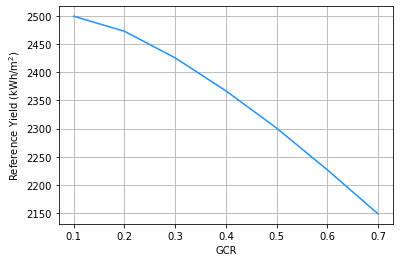

In [30]:
Y_R.plot(color='dodgerblue')
plt.ylabel('Reference Yield (kWh/m$^2$)')
plt.xlabel('GCR')
plt.grid()

As we can see in the figure, there is a trade-off between the reference yield and the GCR. Similarly to what we learnt in Problem 10.4, high land costs will favor selecting high GCR. In short, we can accept a lower yield (and compensate by installing more PV modules) because we save in the required land area.